In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines

# Water

This module manages two important (stock and flow) state variable objects:

1. Groundwater

2. Surfacewater

In [2]:
import sys
sys.path.append('/Users/johnkucharski/Documents/source/cropchoice')
import water
import utilities

<font color=blue>

## Groundwater

The groundwater object keeps track of the groundwater deficit state, which is treated as a stock variable. To constructed a groundwater object, the constructor takes:

1. **active**: bool - True if groundwater can be used in the simulation model, False otherwise. Set to True by default.

2. **deficit**: float - an initial deficit = 0 by default.

3. **max_deficit**: float - the maximum allowable deficit, beyond this point no more groundwater can be extracted,set to *math.inf* by default.

4. **sustainable_yield**: float - the sustainable yield, set to 0 by default.

5. **pumping_cost_function**: Callable[[float], float] - an optional pumping cost function, by default this is parameterized with the 'flat' exponential function with a base of 1, described in the utilities.ipynb (and discussed below).

In the absence of pumping the sustainable yield is treated as recharge, reducing the groundwater deficit.

The default construction of this object is shown below.


In [3]:
G = water.Groundwater()
print(G)

Groundwater(active=True, deficit=0.0, max_deficit=inf, sustainable_yield=0.0, pump_cost_function=<function exponential.<locals>.f at 0x7f84f0c2a8c0>)


<font color=blue>

### Groundwater.deficit

The groundwater object, contains the state variable **deficit**. Negative deficits are treated as surpluses that reduce pumping costs to the base value. The deficit stock is updated by the **pump()** and **recharge()** functions.

The differential equation for the groundwater deficit is $\frac{\delta Q}{dt} =(p - (s + r)) dt$, where $Q$ is the groundwater deficit, and $p, s,$ and $r$ are pumping, sustainable yield, and additional recharge, in timestep $t$. 

### Groundwater.pump(q: float)

The **pump()** function takes one arguments:

* **q**: float - treated as an outflow (i.e. positive number increase the *deficit*)

### Groundwater.recharge(excess_yield: float)

The **recharge()** function takes one argument:

* **excess_yield**: float - an inflow (note: positive numbers decrease the deficit), set to 0 by default.

The **Groundwater.sustainable_yield** property (set though the constructor) is automatically added to the *excess_yield* argument when this function is called. The **excess_yield** argument can be used to modulate the **sustainable_yield** value.

The groundwater object can be used to generically track groundwater usage (without restricting its usage or recharging the groundwater) if: (1) **active** is set to True (default), (2) the initial **deficit** is set to 0 (default), (3) **sustainable_yield** is set to 0 (default), and (4) **max_deficit** is set to math.inf (default).

The formulation in the code block below demonstrates this functionality:

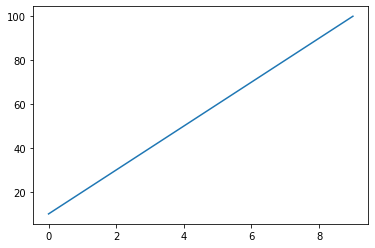

In [4]:
deficits = []
q_pumping = [10 for x in range(0, 10)]
for q in q_pumping:
    G.pump(q)
    deficits.append(G.deficit)
plt.plot(deficits)
plt.show()

<font color=blue>

The next block checks to ensure no defict builds up when the *active* property is set to False.


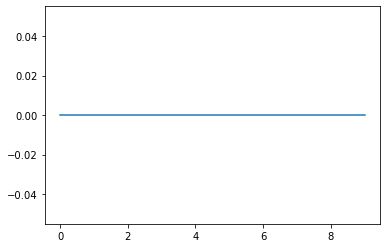

In [5]:
deficits = []
G2 = water.Groundwater(active=False)
q_pumping = [10 for x in range(0, 10)]
for q in q_pumping:
    G2.pump(q)
    deficits.append(G2.deficit)
plt.plot(deficits)
plt.show()

<font color=blue>

The following code block checks the functionality of the recharge() function. In the example below pumping is 10 per timestep, the sustainable yeld of 5 is applied as recharge at the end of each timestep. In the last tims step an excess yield of 45 in applied eliminating the building deficit.

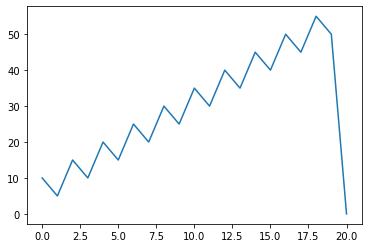

In [6]:
deficits = []
G3 = water.Groundwater(sustainable_yield=5)
q_pumping = [10 for x in range(0, 10)]
for q in q_pumping:
    G3.pump(q)
    deficits.append(G3.deficit)
    G3.recharge()
    deficits.append(G3.deficit)
G3.recharge(excess_yield=45)
deficits.append(G3.deficit)
plt.plot(deficits)
plt.show()

<font color=blue>

#### Groundwater.bid(q: float)

The groundwater object contains a *bid()* function. It takes a single parameter:

1. **q**: float - the desired quantity of groundwater. In the model this is usually based on an unmet surfacewater demand.

The function returns a tuple in the form: **(qa, cost)**, where qa is the available quantity of groundwater, such that $qa \leq q$; and $cost=qa \int_{d}^{d+qa}f(x)$ s.t. $x \epsilon \R:[d, d+qa]$ where $d$ is the current groundwater deficit and $f(x)$ is the *Groundwater.pumping_cost_function*. Specified in the Groundwater constructor. 

If $q=qa$ then *Groundwater.max_deficit*$\leq d+qa, otherwise $qa=d_{max} - d$, where $d_{max}$ is the maximum allowable groundwater deficit, specified as *max_deficit* in the Groundwater constructor.

By default, the Groundwater.pumping_cost_function is a 'flat' exponential function (exponential function with no growth) and base (i.e. cost) of 1 described in the **utilities.ipynb**. This results in linear relationship between price and quantity.

The code block below test this behavior, specifically that the cost of pumping 100 units of deficit groundwater is 100, when the base cost of a unit of deficit groundwater is 1.


In [7]:
G = water.Groundwater()
cost = G.bid(100)
print(cost)

(100, 100.0)


<font color=blue>

The example above places a linear cost on pumping of 1 per unit of pumped water. So, pumping 100 units of water costs 100. 

The exponential function growth rate parameter $r$, that is incorporated in the *pump_cost_function()* is used to escalate the cost of pumping when it exceeds the sustainable rate. The exponential function is described in the *utility.ipynb* notebook. The sustainable rate of pumping is set by the *Groundwater.sustainable_yield* property, described above. 

The code block below shows the escalation of pumping 100 units of deficit groundwater, when the cost increases from its base value of 1 at rate of 1 percent per unit of deficit groundwater.

In [8]:
f = utilities.exponential(base=1, r=0.01)
G = water.Groundwater(deficit=0, sustainable_yield=0, pump_cost_function=f)
cost = G.bid(100)
print(f'{cost}')

(100, 171.33237623739234)


<font color=blue>

In the example above pumping 100 units of groundwater costs 171 (compared to 100 under the no growth assumption).
__________

<font color=green>

## Surfacewater

The surface water object tracks surface water deliveries and supplies. The constructor includes two parameters:

1. available: float - the quantity of surface water available for deliveries, 0 by default.

2. unit_cost: float - an assumed static unit cost per quantity of water, 1 by default.

The available surface water is reduced by the *Surfacewater.deliver(q: float)* function, and reset at the end of timestep by the *Surfacewater.supply(q: float)* function. The *Surfacewater.bid(q: float)* function, like the *Groundwater.bid(q: float)* function, takes a single argument:

1. q: float - the desired quantity of surface water.

It returns a tuple in the form (qa, cost), where qa is the available quantity of surface water such that $q \leq qa$ and cost=qa x *surfacewater.unit_cost*. Unlike the groundwater function the unit_cost of surface water is assumed to be a constant, in any given time step.

The code block below shows how to construct a default surfacewater object, and checks that the *bid()* function return 0, 0 when called with no available surfacewater. 

In [9]:
S = water.Surfacewater()
cost = S.bid(10)
print(S)
print(cost)

Surfacewater(available=0, unit_cost=1)
(0, 0)


<font color=green>

The following codeblock tests the *bid(q=10)* function, when 100 units of surface water are available at a *unit_cost* of 2 (expected output = (10, 10)). Then test the *delivery(q=10)* of that surfacewater bid (expected output Surfacewater.available = 90), and finally resets the surfacewater supply to 100 using the *supply(q=100)* function.

In [11]:
S2 = water.Surfacewater(available=100, unit_cost=2)
print(S2)
cost2 = S.bid(q=10)
print(f'bid output: {cost2}')
S2.deliver(q=10)
print(f'after delivery: {S2}')
S2.supply(q=100)
print(f'after supply: {S2}')

Surfacewater(available=100, unit_cost=2)
bid output: (0, 0)
after delivery: Surfacewater(available=90, unit_cost=2)
after supply: Surfacewater(available=100, unit_cost=2)
